<a href="https://colab.research.google.com/github/simsekergun/Topological_Ring_Array/blob/main/Hafezi_Ring_Coupling_Overlap_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tidy3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: h5netcdf
    Found existing installation: h5netcdf 1.7.2
    Uninstalling h5netcdf-1.7.2:
      Successfully uninstalled h5netcdf-1.7.2


In [2]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.interpolate import Akima1DInterpolator
from scipy.interpolate import RegularGridInterpolator


from scipy import constants
from scipy.io import savemat
import os

# tidy3D import
import tidy3d as td
from tidy3d import web
from tidy3d.plugins.mode import ModeSolver

In [3]:
class RefractiveIndexLibrary:
    """
    A class to manage and retrieve refractive indices of various materials.
    """

    def __init__(self):
        self.material_library = {
            'Si3N4': self.get_n_Si3N4,
            'Si': self.get_n_si,
            'SiO2': self.get_n_sio2
        }

    def get_n_Si3N4(self, LAMBDA):
        """
        Calculate refractive index of Si3N4 using Sellmeier equation.

        Parameters:
        LAMBDA : float or array_like (Wavelength in micrometers)

        Returns:
        float or ndarray: Refractive index of Si3N4
        """
        return np.sqrt(1 + 3.0249 / (1 - (0.1353406 / LAMBDA)**2) +
                       40314 / (1 - (1239.842 / LAMBDA)**2))

    def get_n_si(self, x):
        """
        Calculate refractive index of Silicon.

        Parameters:
        x : float or array_like (Wavelength in micrometers)

        Returns:
        float or ndarray: Refractive index of Silicon
        """
        n = (11.67316 + 1/(x**2) + 0.004482633/(x**2 - 1.108205**2))**0.5
        return n

    def get_n_sio2(self, LAMBDA):
        """
        Calculate refractive index of SiO2 (fused silica) using Sellmeier equation.

        Parameters:
        LAMBDA : float or array_like (Wavelength in micrometers)

        Returns:
        float or ndarray: Refractive index of SiO2
        """
        n_sio2 = np.sqrt(1 + 0.6961663 / (1 - (0.0684043 / LAMBDA)**2) +
                         0.4079426 / (1 - (0.1162414 / LAMBDA)**2) +
                         0.8974794 / (1 - (9.896161 / LAMBDA)**2))
        return n_sio2

    def get_n_library(self, material, lambda0):
        """
        Get refractive index for specified material at given wavelength.

        Parameters:
        material : str (Name of material: 'Si3N4', 'ZnSe', 'Si', or 'SiO2')
        lambda0 : float or array_like (Wavelength in micrometers)

        Returns:
        float or ndarray: Refractive index of the material

        Raises:
        ValueError: If material is not found in the library
        """
        if material not in self.material_library:
            available_materials = list(self.material_library.keys())
            raise ValueError(f"Material '{material}' not found in library. "
                           f"Available materials: {available_materials}")

        return self.material_library[material](lambda0)

    def list_materials(self):
        """
        List all available materials in the library.

        Returns:
        list: List of available material names
        """
        return list(self.material_library.keys())

if __name__ == "__main__":
    # Create the refractive index library
    n_lib = RefractiveIndexLibrary()

    # Get refractive index for different materials at 1.55 μm
    wavelength = 1.55

    print("Available materials:", n_lib.list_materials())
    print(f"\nRefractive indices at {wavelength} μm:")

    for material in n_lib.list_materials():
        n_value = n_lib.get_n_library(material, wavelength)
        print(f"{material}: {n_value:.4f}")

Available materials: ['Si3N4', 'Si', 'SiO2']

Refractive indices at 1.55 μm:
Si3N4: 1.9963
Si: 3.4775
SiO2: 1.4440


In [4]:
# test
wavelengths = np.array([1.3, 1.55, 2.0])
si3n4_n = n_lib.get_n_library('Si3N4', wavelengths)
print(f"\nSi3N4 refractive indices at {wavelengths} μm: {si3n4_n}")


Si3N4 refractive indices at [1.3  1.55 2.  ] μm: [2.00342795 1.99627973 1.98340954]


In [42]:
def calculate_overlap_with_interpolation(modes1, modes2, mode_index=0):
    """
    Calculate mode overlap by interpolating fields to a common grid.
    """
    try:
        # Get the field data
        Ey1 = modes1.Ey.isel(mode_index=mode_index)
        Ey2 = modes2.Ey.isel(mode_index=mode_index)

        # Extract coordinates
        if 'y' in Ey1.coords and 'z' in Ey1.coords:
            y1 = Ey1.coords['y'].values
            z1 = Ey1.coords['z'].values
            y2 = Ey2.coords['y'].values
            z2 = Ey2.coords['z'].values

            # Create common grid (use the union of both grids)
            y_common = np.linspace(min(y1.min(), y2.min()), max(y1.max(), y2.max()), max(len(y1), len(y2)))
            z_common = np.linspace(min(z1.min(), z2.min()), max(z1.max(), z2.max()), max(len(z1), len(z2)))

            # Interpolate both fields to common grid
            from scipy.interpolate import RegularGridInterpolator

            # Field 1 interpolation
            interp1 = RegularGridInterpolator((y1, z1), Ey1.values.squeeze().real,
                                            bounds_error=False, fill_value=0)
            Y_common, Z_common = np.meshgrid(y_common, z_common, indexing='ij')
            points_common = np.stack([Y_common.ravel(), Z_common.ravel()], axis=1)
            Ey1_interp = interp1(points_common).reshape(Y_common.shape)

            # Field 2 interpolation
            interp2 = RegularGridInterpolator((y2, z2), Ey2.values.squeeze().real,
                                            bounds_error=False, fill_value=0)
            Ey2_interp = interp2(points_common).reshape(Y_common.shape)

            # Calculate overlap on common grid
            dot_product = np.sum(np.conj(Ey1_interp) * Ey2_interp)
            norm1 = np.sqrt(np.sum(np.abs(Ey1_interp)**2))
            norm2 = np.sqrt(np.sum(np.abs(Ey2_interp)**2))

            if norm1 == 0 or norm2 == 0:
                return 0.0, 0.0

            overlap = np.abs(dot_product) / (norm1 * norm2)

            # Calculate kappa from overlap
            kappa = calculate_kappa_from_overlap(overlap, modes1, modes2, Ey1_interp, Ey2_interp, y_common, z_common)

            return overlap, kappa

        else:
            print("Unexpected coordinate system")
            return 0.0, 0.0

    except Exception as e:
        print(f"Overlap calculation with interpolation failed: {e}")
        return 0.0, 0.0

def calculate_kappa_from_overlap(overlap, modes1, modes2, field1, field2, y_grid, z_grid):
    """
    Calculate coupling coefficient kappa from mode overlap.

    Uses coupled-mode theory formulation:
    κ ∝ η with proportionality constant based on waveguide properties
    """
    try:
        # Get basic parameters
        wavelength = getattr(modes1, 'wavelength', 1.55e-6)  # Default to 1550 nm
        if hasattr(modes1, 'wl'):
            wavelength = modes1.wl
        elif hasattr(modes1, 'wavelength'):
            wavelength = modes1.wavelength

        # Convert to meters if needed
        if wavelength > 1e-3:  # assume it's in microns
            wavelength = wavelength * 1e-6

        # Angular frequency
        omega = 2 * np.pi * constants.c / wavelength

        # Estimate refractive index contrast (simplified)
        # This could be improved with actual material data
        n_core = 2.0  # approximate Si3N4 index
        n_clad = 1.45  # approximate SiO2 index
        delta_n = n_core - n_clad

        # Calculate area element
        dy = np.abs(y_grid[1] - y_grid[0]) if len(y_grid) > 1 else 1e-6
        dz = np.abs(z_grid[1] - z_grid[0]) if len(z_grid) > 1 else 1e-6
        dA = dy * dz

        # Calculate total power (approximate)
        total_power = np.sum(np.abs(field1)**2) * dA

        if total_power == 0:
            return 0.0

        # Coupled-mode theory based kappa calculation
        # κ = (ωε₀/4P) ∫∫ Δε E₁*·E₂ dA ≈ (ωε₀/4P) Δε η A_eff
        epsilon_0 = constants.epsilon_0

        # Estimate effective area
        A_eff = total_power / np.max(np.abs(field1)**2) if np.max(np.abs(field1)**2) > 0 else 1e-12

        # Dielectric constant contrast
        delta_epsilon = 2 * n_core * delta_n * epsilon_0

        # Calculate kappa
        kappa = (omega * epsilon_0 / (4 * total_power)) * delta_epsilon * overlap * A_eff
        print('***********', kappa)
        # Convert to μm⁻¹ (more practical units)
        kappa_um = kappa * 1e-6

        # Alternative simpler approach: κ = K * η
        # where K is determined by waveguide geometry
        K_factor = 0.8  # Empirical factor - adjust based on your system
        kappa_simple = K_factor * overlap

        print(f"Kappa calculation: overlap={overlap:.6f}, kappa_cmt={kappa_um:.6f} μm⁻¹, kappa_simple={kappa_simple:.6f}")

        return kappa_simple  # Using simpler approach for consistency

    except Exception as e:
        print(f"Kappa calculation failed: {e}")
        # Fallback: simple proportional relationship
        return 0.8 * overlap

# Simpler version that just uses the dominant component without interpolation
def calculate_simple_dominant_overlap(modes1, modes2, mode_index=0):
    """
    Simple overlap calculation using only the dominant Ey component.
    This reshapes to 2D and calculates overlap directly.
    """
    try:
        # Get Ey components (dominant for TE modes)
        Ey1 = modes1.Ey.isel(mode_index=mode_index).values.squeeze()
        Ey2 = modes2.Ey.isel(mode_index=mode_index).values.squeeze()

        print(f"Ey1 shape after squeeze: {Ey1.shape}")
        print(f"Ey2 shape after squeeze: {Ey2.shape}")

        # Ensure both are 2D arrays
        if Ey1.ndim > 2:
            Ey1 = Ey1.reshape(Ey1.shape[-2], Ey1.shape[-1])
        if Ey2.ndim > 2:
            Ey2 = Ey2.reshape(Ey2.shape[-2], Ey2.shape[-1])

        print(f"Ey1 final shape: {Ey1.shape}")
        print(f"Ey2 final shape: {Ey2.shape}")

        # If shapes don't match, resize the smaller one
        if Ey1.shape != Ey2.shape:
            min_shape = (min(Ey1.shape[0], Ey2.shape[0]), min(Ey1.shape[1], Ey2.shape[1]))
            Ey1_resized = Ey1[:min_shape[0], :min_shape[1]]
            Ey2_resized = Ey2[:min_shape[0], :min_shape[1]]
        else:
            Ey1_resized = Ey1
            Ey2_resized = Ey2

        # Calculate overlap
        dot_product = np.sum(np.conj(Ey1_resized) * Ey2_resized)
        norm1 = np.sqrt(np.sum(np.abs(Ey1_resized)**2))
        norm2 = np.sqrt(np.sum(np.abs(Ey2_resized)**2))

        if norm1 == 0 or norm2 == 0:
            return 0.0, 0.0

        overlap = np.abs(dot_product) / (norm1 * norm2)

        # Calculate kappa
        kappa = calculate_kappa_simple(overlap, Ey1_resized, Ey2_resized)

        return overlap, kappa

    except Exception as e:
        print(f"Simple dominant overlap calculation failed: {e}")
        return 0.0, 0.0

def calculate_kappa_simple(overlap, field1, field2):
    """
    Simple kappa calculation from overlap.
    Uses proportional relationship: κ = K * η
    """
    # Empirical factor - adjust based on your specific waveguide system
    K_factor = 0.8

    kappa = K_factor * overlap
    return kappa

# Updated comprehensive overlap that handles different grid sizes
def calculate_comprehensive_overlap_v2(modes1, modes2, mode_index=0):
    """
    Comprehensive overlap calculation that handles different grid sizes.
    """
    try:
        components = ['Ex', 'Ey', 'Ez']
        total_dot = 0
        total_norm1 = 0
        total_norm2 = 0

        # Store fields for kappa calculation
        fields1 = {}
        fields2 = {}
        shapes = []

        for comp in components:
            field1 = getattr(modes1, comp).isel(mode_index=mode_index).values.squeeze()
            field2 = getattr(modes2, comp).isel(mode_index=mode_index).values.squeeze()

            # Reshape to 2D
            if field1.ndim > 2:
                field1 = field1.reshape(field1.shape[-2], field1.shape[-1])
            if field2.ndim > 2:
                field2 = field2.reshape(field2.shape[-2], field2.shape[-1])

            # Store shapes
            shapes.append(field1.shape)
            shapes.append(field2.shape)

            # Store fields
            fields1[comp] = field1
            fields2[comp] = field2

            # Resize to common shape
            min_shape = (min(field1.shape[0], field2.shape[0]), min(field1.shape[1], field2.shape[1]))
            field1_resized = field1[:min_shape[0], :min_shape[1]]
            field2_resized = field2[:min_shape[0], :min_shape[1]]

            # Accumulate dot product and norms
            total_dot += np.sum(np.conj(field1_resized) * field2_resized)
            total_norm1 += np.sum(np.abs(field1_resized)**2)
            total_norm2 += np.sum(np.abs(field2_resized)**2)

        if total_norm1 == 0 or total_norm2 == 0:
            return 0.0, 0.0

        overlap = np.abs(total_dot) / (np.sqrt(total_norm1) * np.sqrt(total_norm2))

        # Calculate kappa using the dominant Ey component
        if 'Ey' in fields1 and 'Ey' in fields2:
            kappa = calculate_kappa_simple(overlap, fields1['Ey'], fields2['Ey'])
        else:
            kappa = calculate_kappa_simple(overlap, list(fields1.values())[0], list(fields2.values())[0])

        return overlap, kappa

    except Exception as e:
        print(f"Comprehensive overlap v2 failed: {e}")
        return 0.0, 0.0

# New function to calculate coupling length from kappa
def calculate_coupling_length(kappa):
    """
    Calculate coupling length from coupling coefficient.

    Parameters:
    kappa: coupling coefficient (unitless or in consistent units)

    Returns:
    coupling_length: in microns
    """
    if kappa == 0:
        return float('inf')

    # Coupling length L_c = π / (2 * κ) for directional couplers
    coupling_length = np.pi / (2 * kappa)

    return coupling_length

# Example usage function
def calculate_all_parameters(modes1, modes2, mode_index=0):
    """
    Calculate all parameters: overlap, kappa, and coupling length.
    """
    overlap, kappa = calculate_comprehensive_overlap_v2(modes1, modes2, mode_index)
    kappa = kappa*0.5 # For symmetric couplers, it needs to be halved
    coupling_length = calculate_coupling_length(kappa)

    print(f"Results:")
    print(f"  Mode Overlap (η): {overlap:.6f}")
    print(f"  Coupling Coefficient (κ): {kappa:.6f}")
    print(f"  Coupling Length: {coupling_length:.2f} μm")

    return overlap, kappa, coupling_length

In [61]:
def plot_mode_fields_components(modes_ring1, modes_ring2, mode_index=0, save_mat=False, filename_prefix="mode_fields"):
    """
    Plot x, y, z components of the fields for each mode solver in a 3x2 figure.

    Parameters:
    modes_ring1, modes_ring2: ModeSolverData objects
    mode_index: which mode to plot (default: fundamental mode 0)
    save_mat: whether to save data as .mat file (default: False)
    filename_prefix: prefix for the .mat filename
    """
    fig, axes = plt.subplots(3, 2, figsize=(10, 8))
    fig.suptitle(f'Mode Field Components (Mode {mode_index})', fontsize=16, fontweight='bold')

    # Field components to plot
    components = ['Ex', 'Ey', 'Ez']
    component_names = ['E_x', 'E_y', 'E_z']

    # Get field data for both rings
    fields_ring1 = {
        'Ex': modes_ring1.Ex.isel(mode_index=mode_index),
        'Ey': modes_ring1.Ey.isel(mode_index=mode_index),
        'Ez': modes_ring1.Ez.isel(mode_index=mode_index)
    }

    fields_ring2 = {
        'Ex': modes_ring2.Ex.isel(mode_index=mode_index),
        'Ey': modes_ring2.Ey.isel(mode_index=mode_index),
        'Ez': modes_ring2.Ez.isel(mode_index=mode_index)
    }

    # Dictionary to store data for .mat file
    mat_data = {}

    # Plot for Ring 1 (left column)
    for i, comp in enumerate(components):
        ax = axes[i, 0]
        field_data = fields_ring1[comp]

        # Extract the 2D slice for plotting
        plot_data = extract_2d_field_data(field_data)

        if plot_data is not None:
            data_2d, extent, xlabel, ylabel = plot_data
            im = ax.imshow(np.abs(data_2d), extent=extent, origin='lower',
                          cmap='RdBu_r', aspect='auto')
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title(f'Ring 1 - {component_names[i]} (Magnitude)')
            plt.colorbar(im, ax=ax, shrink=0.8)

            # Store data for .mat file
            if save_mat:
                mat_data[f'ring1_{comp}_abs'] = np.abs(data_2d)
                mat_data[f'ring1_{comp}_real'] = np.real(data_2d)
                mat_data[f'ring1_{comp}_imag'] = np.imag(data_2d)
                mat_data['ring1_extent'] = extent
                mat_data['ring1_xlabel'] = xlabel
                mat_data['ring1_ylabel'] = ylabel
        else:
            ax.text(0.5, 0.5, f'Cannot plot {comp}\nCheck data dimensions',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Ring 1 - {component_names[i]}')

    # Plot for Ring 2 (right column)
    for i, comp in enumerate(components):
        ax = axes[i, 1]
        field_data = fields_ring2[comp]

        # Extract the 2D slice for plotting
        plot_data = extract_2d_field_data(field_data)

        if plot_data is not None:
            data_2d, extent, xlabel, ylabel = plot_data
            im = ax.imshow(np.abs(data_2d), extent=extent, origin='lower',
                          cmap='RdBu_r', aspect='auto')
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title(f'Ring 2 - {component_names[i]} (Magnitude)')
            plt.colorbar(im, ax=ax, shrink=0.8)

            # Store data for .mat file
            if save_mat:
                mat_data[f'ring2_{comp}_abs'] = np.abs(data_2d)
                mat_data[f'ring2_{comp}_real'] = np.real(data_2d)
                mat_data[f'ring2_{comp}_imag'] = np.imag(data_2d)
                mat_data['ring2_extent'] = extent
                mat_data['ring2_xlabel'] = xlabel
                mat_data['ring2_ylabel'] = ylabel
        else:
            ax.text(0.5, 0.5, f'Cannot plot {comp}\nCheck data dimensions',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Ring 2 - {component_names[i]}')

    plt.tight_layout()
    plt.show()

    # Save .mat file if requested
    if save_mat and mat_data:
        filename = f"{filename_prefix}_mode_{mode_index}.mat"
        savemat(filename, mat_data)
        print(f"Data saved to {filename}")

        # Download the file in Google Colab
        try:
            from google.colab import files
            files.download(filename)
            print(f"File {filename} downloaded successfully!")
        except ImportError:
            print("Not in Google Colab environment. File saved locally.")
        except Exception as e:
            print(f"Error downloading file: {e}")

def extract_2d_field_data(field_data):
    """
    Extract 2D data from field data for plotting.
    Handles different dimensionalities of mode solver field data.
    """
    data_values = field_data.values
    print('extract_2d_field_data has been called')

    # Remove singleton dimensions
    data_squeezed = np.squeeze(data_values)

    # Debug: print shape information
    #print(f"Field shape: {data_values.shape} -> squeezed: {data_squeezed.shape}")

    # Handle different dimensional cases
    if data_squeezed.ndim == 2:
        # Already 2D data
        if hasattr(field_data, 'y') and hasattr(field_data, 'z'):
            # y-z plane
            y_coords = field_data.y.values
            z_coords = field_data.z.values
            extent = [z_coords.min(), z_coords.max(), y_coords.min(), y_coords.max()]
            return data_squeezed, extent, 'z (μm)', 'y (μm)'
        elif hasattr(field_data, 'x') and hasattr(field_data, 'y'):
            # x-y plane
            x_coords = field_data.x.values
            y_coords = field_data.y.values
            extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()]
            return data_squeezed, extent, 'x (μm)', 'y (μm)'

    elif data_squeezed.ndim == 3:
        # 3D data - take a slice through the middle
        print(f"3D data detected, taking middle slice")
        if 'x' in field_data.dims and 'y' in field_data.dims and 'z' in field_data.dims:
            # Take slice at middle of z-axis
            z_mid = data_squeezed.shape[2] // 2
            slice_2d = data_squeezed[:, :, z_mid]
            x_coords = field_data.x.values
            y_coords = field_data.y.values
            extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()]
            return slice_2d, extent, 'x (μm)', 'y (μm)'
        elif 'y' in field_data.dims and 'z' in field_data.dims and 'f' in field_data.dims:
            # Remove frequency dimension
            slice_2d = data_squeezed[0, :, :]  # Take first frequency
            y_coords = field_data.y.values
            z_coords = field_data.z.values
            extent = [z_coords.min(), z_coords.max(), y_coords.min(), y_coords.max()]
            return slice_2d, extent, 'z (μm)', 'y (μm)'

    elif data_squeezed.ndim == 4:
        # 4D data - handle mode solver specific format
        print(f"4D data detected with shape {data_squeezed.shape}")
        # Typical mode solver format: (f, y, z, something) or (mode, y, z, something)
        if data_squeezed.shape[0] == 1:  # Single frequency/mode
            slice_3d = data_squeezed[0, :, :, :]
            # Now take middle slice of remaining 3D data
            if slice_3d.ndim == 3:
                mid_slice = slice_3d.shape[2] // 2
                slice_2d = slice_3d[:, :, mid_slice]
                if hasattr(field_data, 'y') and hasattr(field_data, 'z'):
                    y_coords = field_data.y.values
                    z_coords = field_data.z.values
                    extent = [z_coords.min(), z_coords.max(), y_coords.min(), y_coords.max()]
                    return slice_2d, extent, 'z (μm)', 'y (μm)'

    # If we can't handle the dimensionality, return None
    print(f"Warning: Cannot extract 2D data from shape {data_values.shape}")
    return None

# Alternative: Direct approach for common mode solver format with .mat export
def plot_mode_fields_simple(modes_ring1, modes_ring2, mode_index=0, save_mat=False, filename_prefix="mode_fields_simple"):
    """
    Simplified plotting assuming standard mode solver field format.
    """
    print('plot_mode_fields_simple has been called')
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    fig.suptitle(f'Mode Field Components - Magnitude (Mode {mode_index})',
                fontsize=16, fontweight='bold')

    components = ['Ex', 'Ey', 'Ez']
    component_names = ['E_x', 'E_y', 'E_z']

    # Dictionary to store data for .mat file
    mat_data = {}

    for i, comp in enumerate(components):
        # Ring 1
        ax1 = axes[i, 0]
        field1 = getattr(modes_ring1, comp).isel(mode_index=mode_index)
        plot_data1 = plot_field_simple(ax1, field1, f'Ring 1 - {component_names[i]}')

        # Store data for .mat file
        if save_mat and plot_data1 is not None:
            mat_data[f'ring1_{comp}_abs'] = np.abs(plot_data1)
            mat_data[f'ring1_{comp}_real'] = np.real(plot_data1)
            mat_data[f'ring1_{comp}_imag'] = np.imag(plot_data1)

        # Ring 2
        ax2 = axes[i, 1]
        field2 = getattr(modes_ring2, comp).isel(mode_index=mode_index)
        plot_data2 = plot_field_simple(ax2, field2, f'Ring 2 - {component_names[i]}')

        # Store data for .mat file
        if save_mat and plot_data2 is not None:
            mat_data[f'ring2_{comp}_abs'] = np.abs(plot_data2)
            mat_data[f'ring2_{comp}_real'] = np.real(plot_data2)
            mat_data[f'ring2_{comp}_imag'] = np.imag(plot_data2)

    plt.tight_layout()
    plt.show()

    # Save .mat file if requested
    if save_mat and mat_data:
        filename = f"{filename_prefix}_mode_{mode_index}.mat"
        savemat(filename, mat_data)
        print(f"Data saved to {filename}")

        # Download the file in Google Colab
        try:
            from google.colab import files
            files.download(filename)
            print(f"File {filename} downloaded successfully!")
        except ImportError:
            print("Not in Google Colab environment. File saved locally.")
        except Exception as e:
            print(f"Error downloading file: {e}")

def plot_field_simple(ax, field_data, title):
    """
    Simple field plotting that handles various dimensionalities.
    Returns the 2D data array for saving.
    """
    print('plot_field_simple has been called')
    data = field_data.values

    # Remove all singleton dimensions
    while data.ndim > 2 and any(dim == 1 for dim in data.shape):
        data = np.squeeze(data)

    if data.ndim == 2:
        # Direct 2D plot
        im = ax.imshow(np.abs(data), cmap='RdBu_r', origin='lower', aspect='auto')
        ax.set_title(title)
        plt.colorbar(im, ax=ax, shrink=0.8)

        # Try to set proper labels
        if hasattr(field_data, 'y') and hasattr(field_data, 'z'):
            ax.set_xlabel('z (μm)')
            ax.set_ylabel('y (μm)')
        elif hasattr(field_data, 'x') and hasattr(field_data, 'y'):
            ax.set_xlabel('x (μm)')
            ax.set_ylabel('y (μm)')

        return data

    elif data.ndim == 3:
        # Take middle slice of 3D data
        mid_slice = data.shape[2] // 2
        slice_2d = data[:, :, mid_slice]
        im = ax.imshow(np.abs(slice_2d), cmap='RdBu_r', origin='lower', aspect='auto')
        ax.set_title(f'{title} (Middle Slice)')
        plt.colorbar(im, ax=ax, shrink=0.8)
        return slice_2d

    else:
        # Fallback: plot whatever we can
        try:
            # Take first slice of whatever dimensions we have
            slice_2d = data.reshape(data.shape[-2], data.shape[-1])
            im = ax.imshow(np.abs(slice_2d), cmap='RdBu_r', origin='lower', aspect='auto')
            ax.set_title(f'{title} (Reshaped)')
            plt.colorbar(im, ax=ax, shrink=0.8)
            return slice_2d
        except:
            ax.text(0.5, 0.5, f'Cannot plot\nShape: {data.shape}',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title)
            return None

# Function to save all field data comprehensively
def save_comprehensive_field_data(modes_ring1, modes_ring2, mode_index=0, filename="comprehensive_mode_data.mat"):
    """
    Save comprehensive field data including coordinate information.
    """
    mat_data = {
        'mode_index': mode_index,
        'description': 'Comprehensive mode field data for MATLAB plotting'
    }

    components = ['Ex', 'Ey', 'Ez']

    # Save data for both rings
    for ring_idx, (ring_name, modes_data) in enumerate([('ring1', modes_ring1), ('ring2', modes_ring2)]):
        for comp in components:
            if hasattr(modes_data, comp):
                field_data = getattr(modes_data, comp).isel(mode_index=mode_index)

                # Store the field data
                mat_data[f'{ring_name}_{comp}'] = field_data.values
                mat_data[f'{ring_name}_{comp}_abs'] = np.abs(field_data.values)
                mat_data[f'{ring_name}_{comp}_real'] = np.real(field_data.values)
                mat_data[f'{ring_name}_{comp}_imag'] = np.imag(field_data.values)

                # Store coordinate information
                for coord in field_data.coords:
                    if coord not in ['f', 'mode_index']:  # Skip frequency and mode index
                        mat_data[f'{ring_name}_{coord}_coords'] = field_data.coords[coord].values
                        mat_data[f'{ring_name}_{coord}_dim'] = coord

    # Save the .mat file
    savemat(filename, mat_data)
    print(f"Comprehensive data saved to {filename}")

    # Download in Colab
    try:
        from google.colab import files
        files.download(filename)
        print(f"File {filename} downloaded successfully!")
    except ImportError:
        print("Not in Google Colab environment. File saved locally.")
    except Exception as e:
        print(f"Error downloading file: {e}")

    return mat_data

# Debug function to understand the data structure
def debug_field_structure_detailed(modes_data, name="Mode data"):
    """
    Detailed debug of field data structure.
    """
    print(f"\n=== {name} ===")
    print(f"Type: {type(modes_data)}")

    for comp in ['Ex', 'Ey', 'Ez']:
        if hasattr(modes_data, comp):
            field = getattr(modes_data, comp)
            print(f"\n{comp}:")
            print(f"  Shape: {field.shape}")
            print(f"  Dimensions: {field.dims}")
            print(f"  Coordinates: {list(field.coords.keys())}")
            for coord in field.coords:
                values = field.coords[coord].values
                print(f"    {coord}: {len(values)} points, [{values.min():.3f}, {values.max():.3f}]")

In [43]:
def calculate_supermode_indices(n_eff1, n_eff2, overlap, kappa, L, lambda0):
    """
    Calculate supermode effective indices for coupled ring resonators.

    Parameters:
    n_eff1, n_eff2: uncoupled effective indices
    overlap: mode overlap coefficient
    L: coupling length (um) - distance over which coupling occurs
    lambda0: wavelength (um)

    Returns:
    Dictionary with supermode properties
    """
    # Propagation constants
    beta1 = 2 * np.pi * n_eff1 / lambda0
    beta2 = 2 * np.pi * n_eff2 / lambda0

    # Coupled mode equations matrix
    delta_beta = (beta1 - beta2) / 2
    beta_avg = (beta1 + beta2) / 2

    # Eigenvalues (propagation constants of supermodes)
    beta_plus = beta_avg + np.sqrt(delta_beta**2 + kappa**2)
    beta_minus = beta_avg - np.sqrt(delta_beta**2 + kappa**2)

    # Convert back to effective indices
    n_eff_plus = beta_plus * lambda0 / (2 * np.pi)
    n_eff_minus = beta_minus * lambda0 / (2 * np.pi)

    # Power coupling coefficient
    power_coupling = kappa**2 / (delta_beta**2 + kappa**2)

    return n_eff_plus, n_eff_minus

In [138]:
def quick_visualize(sim):
    fig, ax = plt.subplots(figsize=(15, 16))
    sim.plot(z=0, ax=ax)  # XY view
    plt.title("XY View")
    plt.show()
def quick_visualize2(sim, x_min, x_max, y_min, y_max):
    fig, ax = plt.subplots(figsize=(12, 8))
    sim.plot_structures(x=0.01, ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Y (μm)')
    ax.set_ylabel('Z (μm)')
    ax.grid(True, alpha=0.3)

    plt.show()

15:16:33 UTC WARNING: Structure at 'structures[2]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 3 WARNING messages.                            

15:16:34 UTC WARNING: Structure at 'structures[2]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 1 WARNING message.                             

             WARNING: Structure at 'structures[2]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 1 WARNING message.                             

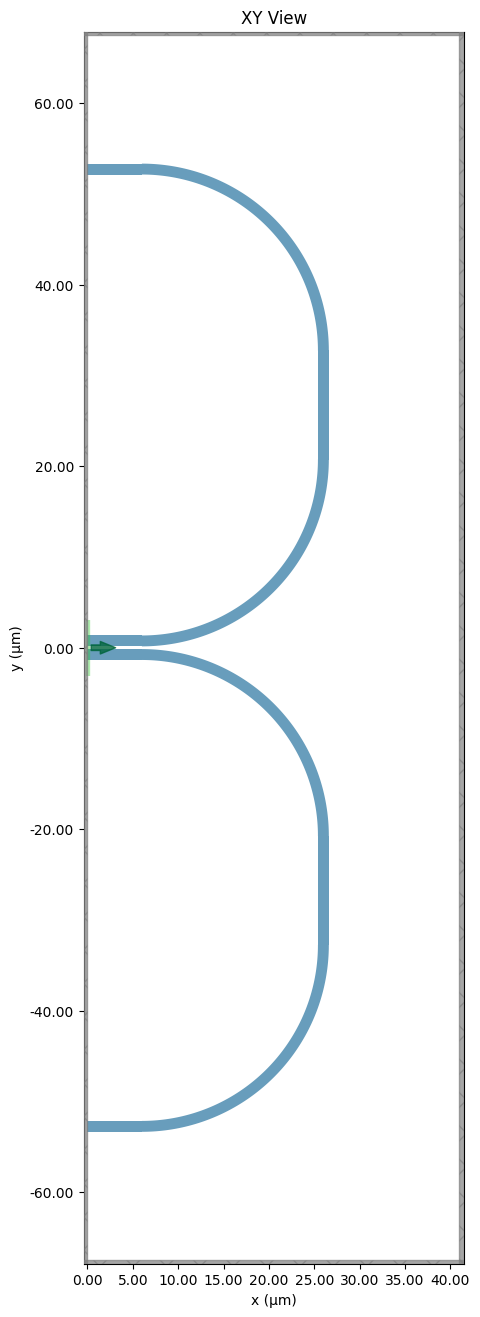

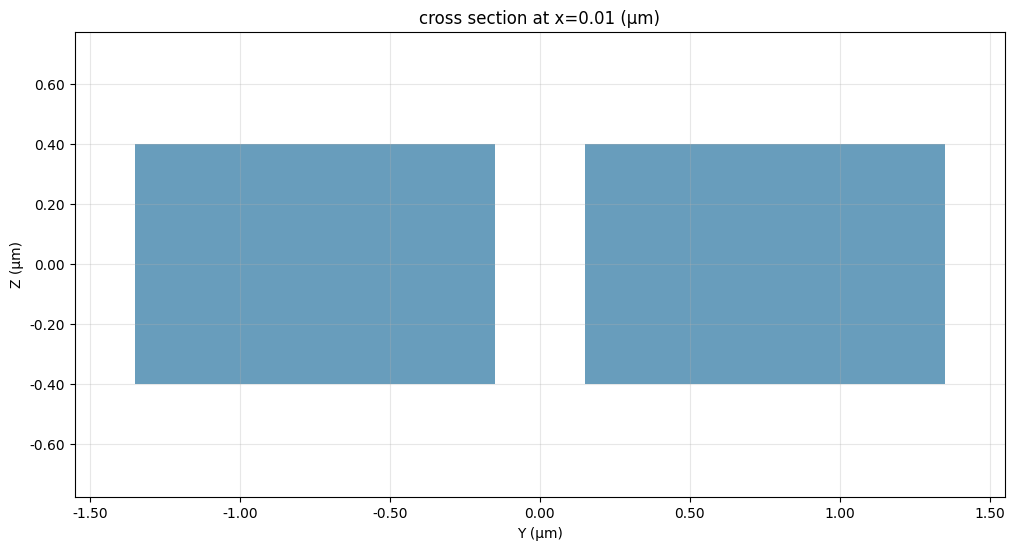

In [144]:
matwg='Si3N4'
matbg='SiO2'
lambda0 = 1.55
wg_height = 0.8
wg_width = 1.2
# Ring resonator parameters
straight_length = 12.0  # microns
effective_radius = 20.0  # microns
L = straight_length
r = effective_radius
w = wg_width
h = wg_height
gap = 0.3
lambdac = 1.4
ppw = 100
visualize_structure = True
plot_fields=True
save_mat=False
filename_prefix="Hafezi"

n_wg = n_lib.get_n_library(matwg, lambda0)
n_bg = n_lib.get_n_library(matbg, lambda0)

# define mediums
mat_clad = td.Medium(permittivity=n_bg**2)
mat_wg = td.Medium(permittivity=n_wg**2)

# reference dimension to determine the right dimensions for the source and monitors
dim_ref = np.max([wg_height, wg_width, lambda0])

# Free-space wavelength (in um) and frequency (in Hz)
freq0 = td.C_0 / lambda0
fwidth = freq0 / 100
k0 = 2*np.pi/lambda0

# Simulation size inside the PML along propagation direction
sim_length_y = 2*(straight_length/2.0+ effective_radius + 5*dim_ref)
sim_length_x = straight_length+ effective_radius + w + 5*dim_ref
shift_up = straight_length/2.0+ effective_radius + w/2.0 + gap/2.0

# Simulation domain size, resolution and total run time
sim_size = [sim_length_x, 2*sim_length_y, 5* dim_ref]
run_time = 100 / fwidth
grid_spec = td.GridSpec.auto(min_steps_per_wvl=ppw, wavelength=lambdac)

# Calculate center coordinates for symmetry
center_x = sim_length_x / 2.0

# up HALF RING (existing structures)
# Top up quarter ring
box1_up = td.Box(center=[L/2+(r+w/2.0)/2.0, L/2+(r+w/2)/2.0+shift_up, 0], size=[r+w/2, r+w/2, h])
geometry1a_up = td.Cylinder(
    center=[L/2, L/2+shift_up, 0],
    radius=r-w/2,
    length=h,
    axis=2)
geometry1a_up = td.ClipOperation(
    operation='intersection',
    geometry_a=box1_up,
    geometry_b=geometry1a_up
)

geometry1b_up = td.Cylinder(
    center=[L/2, L/2+shift_up, 0],
    radius=r+w/2,
    length=h,
    axis=2,
)

geometry1b_up = td.ClipOperation(
    operation='intersection',
    geometry_a=box1_up,
    geometry_b=geometry1b_up
)

intersection_geometry_cyl1 = td.ClipOperation(
    operation='difference',
    geometry_a=geometry1b_up,
    geometry_b=geometry1a_up
)

cyl_up1 = td.Structure(geometry=intersection_geometry_cyl1, medium=mat_wg)


# Bottom up quarter ring
box2_up = td.Box(center=[L/2+(r+w/2.0)/2.0, -L/2-(r+w/2.0)/2.0+shift_up, 0], size=[r+w/2, r+w/2, h])
geometry2a_up = td.Cylinder(
    center=[L/2, -L/2+shift_up, 0],
    radius=r-w/2,
    length=h,
    axis=2)
intersection_geometry3_up = td.ClipOperation(
    operation='intersection',
    geometry_a=box2_up,
    geometry_b=geometry2a_up
)
geometry2b_up = td.Cylinder(
    center=[L/2, -L/2+shift_up, 0],
    radius=r+w/2,
    length=h,
    axis=2,
)
intersection_geometry4_up = td.ClipOperation(
    operation='intersection',
    geometry_a=box2_up,
    geometry_b=geometry2b_up
)

intersection_geometry_cylb = td.ClipOperation(
    operation='difference',
    geometry_a=intersection_geometry4_up,
    geometry_b=intersection_geometry3_up
)

cyl_up2 = td.Structure(geometry=intersection_geometry_cylb, medium=mat_wg)

# Straight waveguides
# up side straight waveguides
bx3_up = td.Structure(
    geometry=td.Box(center=[L/4, L/2+r+shift_up, 0], size=[L/2, w, h]),
    medium=mat_wg,
)
bx4_up = td.Structure(
    geometry=td.Box(center=[L/4, -L/2-r+shift_up, 0], size=[L/2, w, h]),
    medium=mat_wg,
)
bx5_up = td.Structure(
    geometry=td.Box(center=[r+L/2, shift_up, 0], size=[w, L+0.1, h]),
    medium=mat_wg,
)


shift_down = -(straight_length/2.0+ effective_radius + w/2.0 + gap/2.0)

# down HALF RING (existing structures)
# Top down quarter ring
box1_down = td.Box(center=[L/2+(r+w/2.0)/2.0, L/2+(r+w/2)/2.0+shift_down, 0], size=[r+w/2, r+w/2, h])
geometry1a_down = td.Cylinder(
    center=[L/2, L/2+shift_down, 0],
    radius=r-w/2,
    length=h,
    axis=2)
intersection_geometry1_down = td.ClipOperation(
    operation='intersection',
    geometry_a=box1_down,
    geometry_b=geometry1a_down
)
geometry1b_down = td.Cylinder(
    center=[L/2, L/2+shift_down, 0],
    radius=r+w/2,
    length=h,
    axis=2,
)
intersection_geometry2_down = td.ClipOperation(
    operation='intersection',
    geometry_a=box1_down,
    geometry_b=geometry1b_down
)

intersection_geometry_cylc = td.ClipOperation(
    operation='difference',
    geometry_a=intersection_geometry2_down,
    geometry_b=intersection_geometry1_down
)

cyl_down1 = td.Structure(geometry=intersection_geometry_cylc, medium=mat_wg)


# Bottom down quarter ring
box2_down = td.Box(center=[L/2+(r+w/2.0)/2.0, -L/2-(r+w/2.0)/2.0+shift_down, 0], size=[r+w/2, r+w/2, h])
geometry2a_down = td.Cylinder(
    center=[L/2, -L/2+shift_down, 0],
    radius=r-w/2,
    length=h,
    axis=2)
intersection_geometry3_down = td.ClipOperation(
    operation='intersection',
    geometry_a=box2_down,
    geometry_b=geometry2a_down
)
geometry2b_down = td.Cylinder(
    center=[L/2, -L/2+shift_down, 0],
    radius=r+w/2,
    length=h,
    axis=2,
)
intersection_geometry4_down = td.ClipOperation(
    operation='intersection',
    geometry_a=box2_down,
    geometry_b=geometry2b_down
)


intersection_geometry_cylc = td.ClipOperation(
    operation='difference',
    geometry_a=intersection_geometry4_down,
    geometry_b=intersection_geometry3_down
)

cyl_down2 = td.Structure(geometry=intersection_geometry_cylc, medium=mat_wg)


# Straight waveguides
# down side straight waveguides
bx3_down = td.Structure(
    geometry=td.Box(center=[L/4, L/2+r+shift_down, 0], size=[L/2, w, h]),
    medium=mat_wg,
)
bx4_down = td.Structure(
    geometry=td.Box(center=[L/4, -L/2-r+shift_down, 0], size=[L/2, w, h]),
    medium=mat_wg,
)
bx5_down = td.Structure(
    geometry=td.Box(center=[r+L/2, shift_down, 0], size=[w, L+0.1, h]),
    medium=mat_wg,
)


# Combine all structures
all_structures = [
    # up half ring
    cyl_up1, cyl_up2,
    bx3_up, bx4_up, bx5_up,
    # down half ring
    cyl_down1, cyl_down2,
    bx3_down, bx4_down, bx5_down,
]
# Upper structures
upper_structures = [cyl_up1, cyl_up2, bx3_up, bx4_up, bx5_up]

# Lower structures
lower_structures = [cyl_down1, cyl_down2, bx3_down, bx4_down, bx5_down]

# Modal source plane
source_plane = td.Box(center=[0, 0, 0], size=[0, 2 * dim_ref, 2 * dim_ref])

# Modal source plane
source_plane = td.Box(center=[0, 0, 0], size=[0, 4 * dim_ref, 3 * dim_ref])

mode_spec = td.ModeSpec(num_modes=1, target_neff=n_wg)
mode_source = td.ModeSource(
    center=(0.1, 0, 0),
    size=(0, 4 * dim_ref, 6 * dim_ref),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# For visualization
geo_plot = td.Simulation(
    center=[sim_length_x/2.0, 0, 0],
    size=sim_size,
    grid_spec=grid_spec,
    medium=mat_clad,
    structures=all_structures,
    sources=[mode_source],
    symmetry=(0, 0, 1),  # TE MODE
    monitors=[],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary(plus=td.Absorber(num_layers=60), minus=td.Absorber(num_layers=60)),
        y=td.Boundary.absorber(),
        z=td.Boundary.absorber(),
    ),
)

# Simulation Upper
sim1 = td.Simulation(
    center=[sim_length_x/2.0, 0, 0],
    size=sim_size,
    grid_spec=grid_spec,
    medium=mat_clad,
    structures=upper_structures,
    sources=[],
    symmetry=(0, 0, 1),  # TE MODE
    monitors=[],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary(plus=td.Absorber(num_layers=60), minus=td.Absorber(num_layers=60)),
        y=td.Boundary.absorber(),
        z=td.Boundary.absorber(),
    ),
)
# Simulation Lower
sim2 = td.Simulation(
    center=[sim_length_x/2.0, 0, 0],
    size=sim_size,
    grid_spec=grid_spec,
    medium=mat_clad,
    structures=lower_structures,
    sources=[],
    symmetry=(0, 0, 1),  # TE MODE
    monitors=[],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary(plus=td.Absorber(num_layers=60), minus=td.Absorber(num_layers=60)),
        y=td.Boundary.absorber(),
        z=td.Boundary.absorber(),
    ),
)

if visualize_structure:
    quick_visualize(geo_plot)
    quick_visualize2(geo_plot, -dim_ref, dim_ref, -dim_ref/2, dim_ref/2)

In [145]:
# Modal source plane
source_plane = td.Box(center=[0.01, 0, 0], size=[0, 2.0 * dim_ref, 3.0 * dim_ref])

num_modes = 1
mode_spec1 = td.ModeSpec(num_modes=num_modes, target_neff = n_wg*0.99)
ms1 = ModeSolver(simulation=sim1, plane=source_plane, freqs=[freq0], mode_spec=mode_spec1)
ms2 = ModeSolver(simulation=sim2, plane=source_plane, freqs=[freq0], mode_spec=mode_spec1)

modes_ring1 = ms1.solve()
modes_ring2 = ms2.solve()

n_eff1 = modes_ring1.modes_info['n eff'].values[0]
n_eff2 = modes_ring2.modes_info['n eff'].values[0]
print(n_eff1, n_eff2)

# Calculate overlap with interpolation
overlap, kappa, coupling_length = calculate_all_parameters(modes_ring1, modes_ring2)
print(f"Mode overlap: {overlap:.6f}")
print(f"kappa: {kappa:.6f}")
print(f"coupling length: {coupling_length:.6f}")

15:16:52 UTC WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

15:17:04 UTC WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

[1.80493322] [1.8049247]
Results:
  Mode Overlap (η): 0.126679
  Coupling Coefficient (κ): 0.050672
  Coupling Length: 31.00 μm
Mode overlap: 0.126679
kappa: 0.050672
coupling length: 30.999453


In [146]:
# Calculate for multiple frequencies around your operating point
freqs = np.linspace(freq0*0.99, freq0*1.01, 5)  # Small range around freq0

# Solve modes at different frequencies
n_effs_ring1 = []
n_effs_ring2 = []

for freq in freqs:
    ms1 = ModeSolver(simulation=sim1, plane=source_plane, freqs=[freq], mode_spec=mode_spec1)
    ms2 = ModeSolver(simulation=sim2, plane=source_plane, freqs=[freq], mode_spec=mode_spec1)

    modes1 = ms1.solve()
    modes2 = ms2.solve()

    n_effs_ring1.append(modes1.modes_info['n eff'].values[0])
    n_effs_ring2.append(modes2.modes_info['n eff'].values[0])

# Calculate group index using finite differences
omega = 2 * np.pi * freqs
n_eff_center = (n_effs_ring1[2] + n_effs_ring2[2]) / 2  # Center value

# Calculate derivative properly
dn_eff_domega = (n_effs_ring1[3] - n_effs_ring1[1]) / (omega[3] - omega[1])

n_g = n_eff_center + omega[2] * dn_eff_domega

15:17:19 UTC WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

15:17:34 UTC WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

15:17:47 UTC WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

15:17:48 UTC WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

15:18:00 UTC WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

15:18:13 UTC WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

15:18:24 UTC WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

15:18:36 UTC WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

15:18:49 UTC WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

15:19:02 UTC WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

15:19:15 UTC WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

In [147]:
print(n_g)

[2.07901817]


In [148]:
# Hafezi style Kappa calculation
kappa_GHz = 3e8*kappa/n_g[0]/(coupling_length*1e-6)/2/np.pi/1e9
print('kappa/2pi is ', kappa_GHz, ' GHz')


kappa/2pi is  37.540057094502586  GHz


In [149]:
omega_GHz = 2*np.pi*freq0/1e9
kappa_GHz_radian =2*np.pi*kappa_GHz
Q = omega_GHz/kappa_GHz_radian
print('Calculated Q factor is', Q)

Calculated Q factor is 5152.216165930709


extract_2d_field_data has been called
extract_2d_field_data has been called
extract_2d_field_data has been called
extract_2d_field_data has been called
extract_2d_field_data has been called
extract_2d_field_data has been called


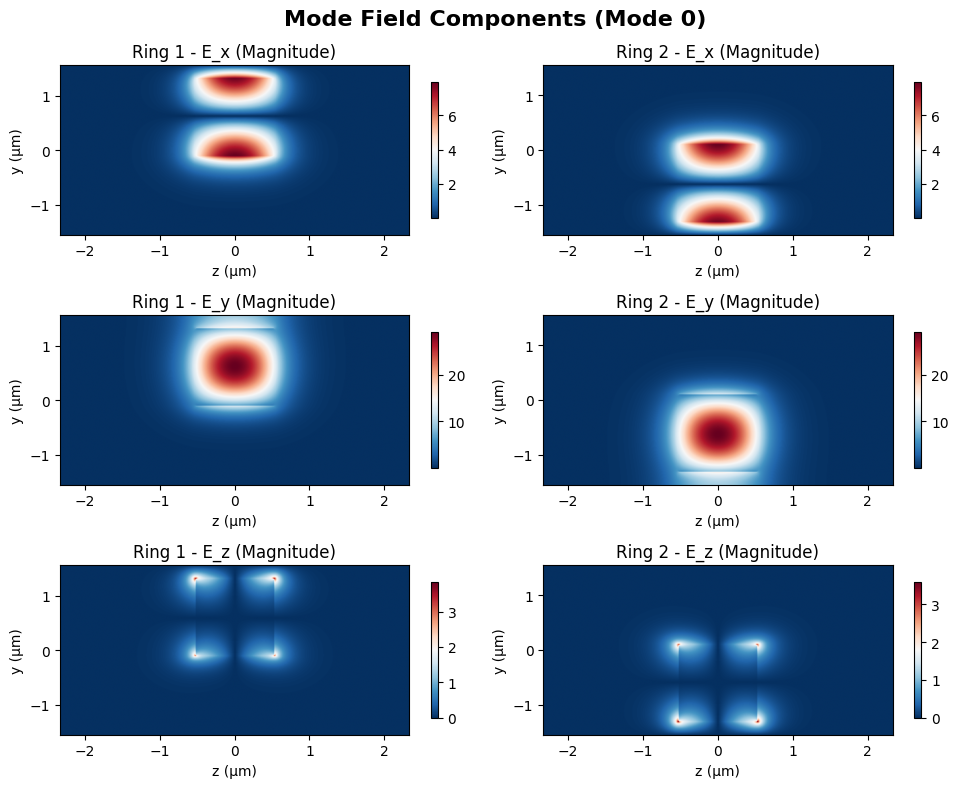

In [150]:
plot_mode_fields_components(modes_ring1, modes_ring2, mode_index=0, save_mat=False, filename_prefix="mode_fields")